In [1]:
%load_ext autoreload
%autoreload 2

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist
import time

from processor.dielectron_mass import dielectron_mass
from Tools.config_helpers import loadConfig
from klepto.archives import dir_archive

year = 2018

In [ ]:
from processor.default_accumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

from processor.meta_processor import get_sample_meta

overwrite = True
local = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'dielectron_mass_data'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)


# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples(year)

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['Data'], year, redirector=redirector_ucsd, small=False)

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

#meta = get_sample_meta(fileset, samples)

chunksize = 250000

if local:

    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.futures_executor

else:
    from Tools.helpers import get_scheduler_address
    from dask.distributed import Client, progress
    
    scheduler_address = get_scheduler_address()
    c = Client(scheduler_address)
    
    def unique(filename):
        file, ext = os.path.splitext(filename)
        counter = 0
        while os.path.exists(filename):
            counter += 1
            filename = file + str(counter) + ext
        return filename

    tstart = time.time()
    
    from dask.distributed import performance_report
    fname = unique("dask/dask-report_chunksize=" + str(chunksize/1000) + "K.html")
    
    exe_args = {
        'client': c,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        #"skipbadfiles": True,
        'savemetrics': True
    }
    exe = processor.dask_executor


if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')
    
else:
    print ("I'm running now")
    with performance_report(filename=fname):
        output = processor.run_uproot_job(
            fileset,
            "Events",
            dielectron_mass(year=year, variations=[], accumulator=desired_output),
            exe,
            exe_args,
            chunksize=50000,
            )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()
    

In [ ]:
import cloudpickle
import gzip
dt = time.time() - tstart

print('Done!')
print("Events / s / thread: {:,.0f}".format(output[1]['entries'].value / output[1]['processtime'].value))
print("Events / s: {:,.0f}".format(output[1]['entries'].value / dt))

In [ ]:
print(output[0]['totalEvents']['all']/1e6)

In [ ]:
from processor.default_accumulators import desired_output, add_processes_to_output

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset, nano_mapping

from processor.meta_processor import get_sample_meta

overwrite = True
local = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'dielectron_mass_data'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)


# get a python dictionary of all NanoAOD samples
# The samples definitions can be found in data/samples.yaml
samples = get_samples(year)

# make a fileset, taking the definitions in Tools/nano_mapping.py
fileset = make_fileset(['Data'], year, redirector=redirector_ucsd, small=False)

# in order for cutflows to work we need to add every process to the output accumulator
add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

#meta = get_sample_meta(fileset, samples)

if local:

    exe_args = {
        'workers': 16,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
    }
    exe = processor.futures_executor

else:
    from Tools.helpers import get_scheduler_address
    from dask.distributed import Client, progress
    
    scheduler_address = get_scheduler_address()
    c = Client(scheduler_address)
    
    def unique(filename):
        file, ext = os.path.splitext(filename)
        counter = 0
        while os.path.exists(filename):
            counter += 1
            filename = file + str(counter) + ext
        return filename

    tstart = time.time()
    
    from dask.distributed import performance_report
    fname = unique("dask/dask-report_chunksize=" + str(chunksize/1000) + "K.html")
    
    exe_args = {
        'client': c,
        'function_args': {'flatten': False},
        "schema": NanoAODSchema,
        "skipbadfiles": True,
        'savemetrics': True
    }
    exe = processor.dask_executor


if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')
    
else:
    print ("I'm running now")
    output = processor.run_uproot_job(
        fileset,
        "Events",
        dielectron_mass(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=25000,
        )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()
    

samples_2018.yaml
I'm running now


Preprocessing:   0%|          | 0/946 [00:00<?, ?file/s]

Processing:   0%|          | 0/1411 [00:00<?, ?chunk/s]

Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/home/users/ewallace/miniconda3/envs/daskanalysisenv/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/users/ewallace/miniconda3/envs/daskanalysisenv/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/users/ewallace/miniconda3/envs/daskanalysisenv/lib/python3.8/concurrent/futures/process.py", line 394, in _queue_management_worker
    work_item.future.set_exception(bpe)
  File "/home/users/ewallace/miniconda3/envs/daskanalysisenv/lib/python3.8/concurrent/futures/_base.py", line 547, in set_exception
    raise InvalidStateError('{}: {!r}'.format(self._state, self))
concurrent.futures._base.InvalidStateError: CANCELLED: <Future at 0x7fd3001245e0 state=cancelled>


In [3]:
# import the plotting libararies: matplotlib and mplhep

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import numpy as np


# load the functions to make a nice plot from the output histograms
# and the scale_and_merge function that scales the individual histograms
# to match the physical cross section

from plots.helpers import makePlot, scale_and_merge

# define a few axes that we can use to rebin our output histograms

N_bins         = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red     = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins        = hist.Bin('pt', r'$p_{T}\ (GeV)$', np.array([15, 40, 60, 80, 100, 200, 300]))
pt_fine_bins   = hist.Bin('pt', r'$p_{T}\ (GeV)$', 300, 0, 300)
pt_rebin       = hist.Bin('pt', r'$p_{T}\ (GeV)$', 75, 0, 150)
eta_bins       = hist.Bin('eta', r'$\eta $', np.array([0, 0.8, 1.479, 2.5]))
eta_rebin      = hist.Bin('eta', r'$\eta $', 25, -2.5, 2.5)    
phi_bins       = hist.Bin('phi', r'$\phi $', 16, -3.2, 3.2)
mass_bins      = hist.Bin('mass', r'$mass (GeV/c^2)$', 19, 48, 124)

# 1D Histograms

In [4]:
from yahist import Hist1D, Hist2D

In [5]:
def get_total(histos, keys):
        tmp = Hist1D.from_bincounts(np.zeros(len(histos[keys[0]].counts)), histos[keys[0]].edges, )
        for key in keys:
            tmp += histos[key]
        return tmp

def add_uncertainty(hist, ax, ratio=False):
    opts = {'step': 'post', 'label': 'Uncertainty', 'hatch': '///',
                    'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0, 'zorder':10.}
    
    if ratio:
        down = np.ones(len(hist.counts)) - hist.errors/hist.counts
        up = np.ones(len(hist.counts)) + hist.errors/hist.counts
    else:
        down = hist.counts-hist.errors
        up = hist.counts+hist.errors
    ax.fill_between(x=hist.edges, y1=np.r_[down, down[-1]], y2=np.r_[up, up[-1]], **opts)

In [6]:
import gzip
import pickle
import cloudpickle

In [ ]:
outname = 'dielectron_data_'+str(year)
os.system("mkdir -p histos/")
print('Saving output in %s...'%("histos/" + outname + ".pkl.gz"))
with gzip.open("histos/" + outname + ".pkl.gz", "wb") as fout:
    cloudpickle.dump(output, fout)
print('Done!')

In [7]:
path = 'histos/dielectron_mc_2018.pkl.gz'
with gzip.open(path) as fin:
    mc_output= pickle.load(fin)
    
path = 'histos/dielectron_data_2018.pkl.gz'
with gzip.open(path) as fin:
    output= pickle.load(fin)

In [12]:
tmp1 = output[0]['dilep_mass1'].copy()
tmp1 = tmp1.rebin('mass', mass_bins)
tmp1 = tmp1.rebin('pt', pt_rebin)

h1 = Hist1D.from_bincounts(
    tmp1.sum('pt', 'dataset').values()[()].T,
    (tmp1.axis('mass').edges()),
    errors = np.sqrt(tmp1.sum('pt', 'dataset').values(sumw2=True)[()][1].T),
)

h2 = Hist1D.from_bincounts(
    tmp1.sum('mass', 'dataset').values()[()].T,
    (tmp1.axis('pt').edges()),
    errors = np.sqrt(tmp1.sum('mass', 'dataset').values(sumw2=True)[()][1].T),
)

tmp2 = mc_output['dilep_mass1'].copy()
tmp2 = tmp2.rebin('mass', mass_bins)
tmp2 = tmp2.rebin('pt', pt_rebin)

if year == 2017:

    h1_DY = Hist1D.from_bincounts(
        tmp2.sum('pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)].T,
        (tmp2.axis('mass').edges()),
        errors = np.sqrt(tmp2.sum('pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)][1].T),
    )

    h1_DY = h1_DY*6021.0*1000/48968256.0*60

    h1_TT = Hist1D.from_bincounts(
        tmp2.sum('pt').values()[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)].T,
        (tmp2.axis('mass').edges()),
        errors = np.sqrt(tmp2.sum('pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)][1].T),
    )

    h1_TT = h1_TT*87.315*1000/4960123622.722055*60

    h2_DY = Hist1D.from_bincounts(
        tmp2.sum('mass').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)].T,
        (tmp2.axis('pt').edges()),
        errors = np.sqrt(tmp2.sum('mass').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)][1].T),
    )

    h2_DY = h2_DY*6021.0*1000/48968256.0*60

    h2_TT = Hist1D.from_bincounts(
        tmp2.sum('mass').values()[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)].T,
        (tmp2.axis('pt').edges()),
        errors = np.sqrt(tmp2.sum('mass',).values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)][1].T),
    )
    h2_TT = h2_TT*87.315*1000/4960123622.722055*60
    
if year == 2018:
    h1_DY = Hist1D.from_bincounts(
        tmp2.sum('pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('mass').edges()),
        errors = np.sqrt(tmp2.sum('pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h1_DY = h1_DY*6021.0*1000/100108281.94794683*60

    h1_TT = Hist1D.from_bincounts(
        tmp2.sum('pt').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('mass').edges()),
        errors = np.sqrt(tmp2.sum('pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h1_TT = h1_TT*87.315*1000/4635769336.539396*60
    
    h1_WZ = Hist1D.from_bincounts(
        tmp2.sum('pt').values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('mass').edges()),
        errors = np.sqrt(tmp2.sum('pt').values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )
    
    h1_WZ = h1_WZ*4.666*1000/97448995.340155*60

    h2_DY = Hist1D.from_bincounts(
        tmp2.sum('mass').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('pt').edges()),
        errors = np.sqrt(tmp2.sum('mass').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h2_DY = h2_DY*6021.0*1000/100108281.94794683*60

    h2_TT = Hist1D.from_bincounts(
        tmp2.sum('mass').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('pt').edges()),
        errors = np.sqrt(tmp2.sum('mass',).values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )
    
    h2_TT = h2_TT*87.315*1000/4635769336.539396*60
    
    h2_WZ = Hist1D.from_bincounts(
        tmp2.sum('mass').values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('pt').edges()),
        errors = np.sqrt(tmp2.sum('mass').values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )
    
    h2_WZ = h2_WZ*4.666*1000/97448995.340155*60

In [10]:
tmp1.sum('pt').values()

{('/EGamma/Run2018D-02Apr2020-v1/NANOAOD',): array([      0.,       0.,       0.,       0.,       0.,       0.,
              0.,  134227.,  350247., 1300844., 3307126., 1524302.,
         328708.,  118429.,   39184.,       0.,       0.,       0.,
              0.]),
 ('/EGamma/Run2018C-02Apr2020-v1/NANOAOD',): array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
         29179.,  74754., 276918., 730368., 332954.,  70062.,  25222.,
          8452.,      0.,      0.,      0.,      0.]),
 ('/EGamma/Run2018B-02Apr2020-v1/NANOAOD',): array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
         29587.,  75888., 284011., 745263., 339211.,  71320.,  25933.,
          8652.,      0.,      0.,      0.,      0.]),
 ('/EGamma/Run2018A-02Apr2020-v1/NANOAOD',): array([      0.,       0.,       0.,       0.,       0.,       0.,
              0.,   53938.,  139332.,  520936., 1390157.,  624454.,
         129899.,   47336.,   16005.,       0.,       0.,       0.,
  

In [13]:
hists = {'mass_data_OS': h1,
         'mass_DY_OS':   h1_DY,
         'mass_TT_OS':   h1_TT,
         'mass_WZ_OS':   h1_WZ,
}

hists['mass_TT_OS'].label = '$TT\ (OS)$'
hists['mass_TT_OS'].color = '#8AC926'

hists['mass_DY_OS'].label = '$DY\ (OS)$'
hists['mass_DY_OS'].color = '#FFCA3A'

hists['mass_WZ_OS'].label = '$WZ\ (OS)$'
hists['mass_WZ_OS'].color = '#C93126'

keys = ['mass_WZ_OS', 'mass_TT_OS', 'mass_DY_OS']

total_mc = get_total(hists, keys)

ratio = (hists['mass_data_OS']).divide(hists['mass_TT_OS']+hists['mass_DY_OS']+hists['mass_WZ_OS'])

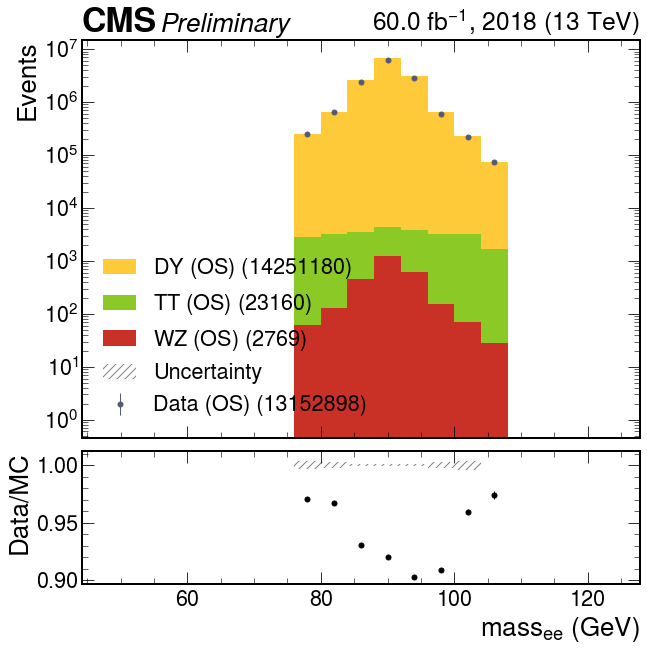

In [15]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['mass_DY_OS'].edges,
    w2=[(hists[x].errors)**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['mass_data_OS'].counts],
    hists['mass_data_OS'].edges,
    w2=(hists['mass_data_OS'].errors)**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['mass_data_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['mass_data_OS'].counts/((hists['mass_TT_OS'].counts+hists['mass_DY_OS'].counts+hists['mass_WZ_OS'].counts)**2)],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$mass_{ee}\ (GeV)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)


ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zmass_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zmass_data.pdf')

In [16]:
hists = {'pt_data_OS':   h2,
         'pt_DY_OS':     h2_DY,
         'pt_TT_OS':     h2_TT,
         'pt_WZ_OS': h2_WZ,
        }

hists['pt_TT_OS'].label = '$TT\ (OS)$'
hists['pt_TT_OS'].color = '#8AC926'

hists['pt_DY_OS'].label = '$DY\ (OS)$'
hists['pt_DY_OS'].color = '#FFCA3A'

hists['pt_WZ_OS'].label = '$WZ\ (OS)$'
hists['pt_WZ_OS'].color = '#C93126'

keys = ['pt_WZ_OS', 'pt_TT_OS', 'pt_DY_OS']

total_mc = get_total(hists, keys)

ratio = (hists['pt_data_OS']).divide(hists['pt_TT_OS']+hists['pt_DY_OS']+hists['pt_WZ_OS'])

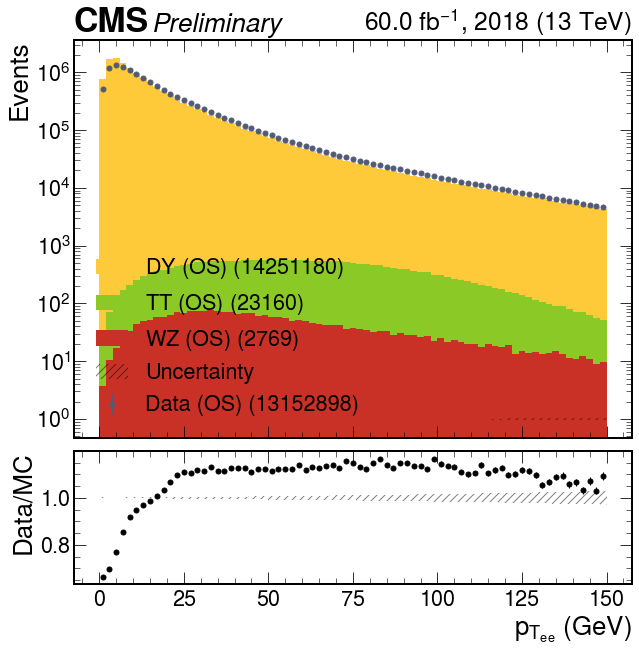

In [17]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['pt_DY_OS'].edges,
    w2=[hists[x].errors**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['pt_data_OS'].counts],
    hists['pt_data_OS'].edges,
    w2=hists['pt_data_OS'].errors**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['pt_data_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['pt_data_OS'].counts/(hists['pt_TT_OS'].counts+hists['pt_DY_OS'].counts)**2],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$p_{T_{ee}}\ (GeV)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zpt_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zpt_data.pdf')

In [21]:
tmp1 = output[0]['electron_data1'].copy()
tmp1 = tmp1.rebin('pt', pt_rebin)
tmp1 = tmp1.rebin('eta', eta_rebin)

tmp2 = output[0]['electron_data2'].copy()
tmp2 = tmp2.rebin('pt', pt_rebin)
tmp2 = tmp2.rebin('eta', eta_rebin)

tmp3 = mc_output['electron_data1'].copy()
tmp3 = tmp3.rebin('pt', pt_rebin)
tmp3 = tmp3.rebin('eta', eta_rebin)

tmp4 = mc_output['electron_data2'].copy()
tmp4 = tmp4.rebin('pt', pt_rebin)
tmp4 = tmp4.rebin('eta', eta_rebin)


h1 = Hist1D.from_bincounts(
    tmp1.sum('dataset', 'phi', 'eta').values()[()].T,
    (tmp1.axis('pt').edges()),
    errors = np.sqrt(tmp1.sum('dataset', 'phi', 'eta').values(sumw2=True)[()][1].T),
)

h2 = Hist1D.from_bincounts(
    tmp2.sum('dataset', 'phi', 'eta').values()[()].T,
    (tmp2.axis('pt').edges()),
    errors = np.sqrt(tmp2.sum('dataset', 'phi', 'eta').values(sumw2=True)[()][1].T),
)
    
h3 = Hist1D.from_bincounts(
    tmp1.sum('dataset', 'phi', 'pt').values()[()].T,
    (tmp1.axis('eta').edges()),
    errors = np.sqrt(tmp1.sum('dataset', 'phi', 'pt').values(sumw2=True)[()][1].T),
)
    
    
h4 = Hist1D.from_bincounts(
    tmp2.sum('dataset', 'phi', 'pt').values()[()].T,
    (tmp2.axis('eta').edges()),
    errors = np.sqrt(tmp2.sum('dataset', 'phi', 'pt').values(sumw2=True)[()][1].T),
)
    
h5 = Hist1D.from_bincounts(
    tmp1.sum('dataset', 'eta', 'pt').values()[()].T,
    (tmp1.axis('phi').edges()),
    errors = np.sqrt(tmp1.sum('dataset', 'eta', 'pt').values(sumw2=True)[()][1].T),
)
    
    
h6 = Hist1D.from_bincounts(
    tmp2.sum('dataset', 'eta', 'pt').values()[()].T,
    (tmp2.axis('phi').edges()),
    errors = np.sqrt(tmp2.sum('dataset', 'eta', 'pt').values(sumw2=True)[()][1].T),
)




if year == 2017:
    h1_DY = Hist1D.from_bincounts(
        tmp3.sum('phi', 'eta').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)].T,
        (tmp3.axis('pt').edges()),
        errors = np.sqrt(tmp3.sum('phi', 'eta').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)][1].T),
    )

    h2_DY = Hist1D.from_bincounts(
        tmp4.sum('phi', 'eta').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)].T,
        (tmp4.axis('pt').edges()),
        errors = np.sqrt(tmp4.sum('phi', 'eta').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)][1].T),
    )

    h3_DY = Hist1D.from_bincounts(
        tmp3.sum('phi', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)].T,
        (tmp3.axis('eta').edges()),
        errors = np.sqrt(tmp3.sum('phi', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)][1].T),
    )

    h4_DY = Hist1D.from_bincounts(
        tmp4.sum('phi', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)].T,
        (tmp4.axis('eta').edges()),
        errors = np.sqrt(tmp4.sum('phi', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)][1].T),
    )

    h5_DY = Hist1D.from_bincounts(
        tmp3.sum('eta', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)].T,
        (tmp3.axis('phi').edges()),
        errors = np.sqrt(tmp3.sum('eta', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)][1].T),
    )

    h6_DY = Hist1D.from_bincounts(
        tmp4.sum('eta', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)].T,
        (tmp4.axis('phi').edges()),
        errors = np.sqrt(tmp4.sum('eta', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIFall17NanoAODv7-PU2017RECOSIMstep_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8_ext1-v1/NANOAODSIM',)][1].T),
    )

    h1_DY = h1_DY*6021.0*1000/48968256.0*60
    h2_DY = h2_DY*6021.0*1000/48968256.0*60
    h3_DY = h3_DY*6021.0*1000/48968256.0*60
    h4_DY = h4_DY*6021.0*1000/48968256.0*60
    h5_DY = h5_DY*6021.0*1000/48968256.0*60
    h6_DY = h6_DY*6021.0*1000/48968256.0*60


    h1_TT = Hist1D.from_bincounts(
        tmp3.sum('phi', 'eta').values()[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)].T,
        (tmp3.axis('pt').edges()),
        errors = np.sqrt(tmp3.sum('phi', 'eta').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)][1].T),
    )

    h2_TT = Hist1D.from_bincounts(
        tmp4.sum('phi', 'eta').values()[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)].T,
        (tmp4.axis('pt').edges()),
        errors = np.sqrt(tmp4.sum('phi', 'eta').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)][1].T),
    )

    h3_TT = Hist1D.from_bincounts(
        tmp3.sum('phi', 'pt').values()[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)].T,
        (tmp3.axis('eta').edges()),
        errors = np.sqrt(tmp3.sum('phi', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)][1].T),
    )

    h4_TT = Hist1D.from_bincounts(
        tmp4.sum('phi', 'pt').values()[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)].T,
        (tmp4.axis('eta').edges()),
        errors = np.sqrt(tmp4.sum('phi', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)][1].T),
    )

    h5_TT = Hist1D.from_bincounts(
        tmp3.sum('eta', 'pt').values()[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)].T,
        (tmp3.axis('phi').edges()),
        errors = np.sqrt(tmp3.sum('eta', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)][1].T),
    )

    h6_TT = Hist1D.from_bincounts(
        tmp4.sum('eta', 'pt').values()[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)].T,
        (tmp4.axis('phi').edges()),
        errors = np.sqrt(tmp4.sum('eta', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_new_pmx_102X_mc2017_realistic_v8-v1/NANOAODSIM',)][1].T),
    )

    h1_TT = h1_TT*87.315*1000/4960123622.722055*60
    h2_TT = h2_TT*87.315*1000/4960123622.722055*60
    h3_TT = h3_TT*87.315*1000/4960123622.722055*60
    h4_TT = h4_TT*87.315*1000/4960123622.722055*60
    h5_TT = h5_TT*87.315*1000/4960123622.722055*60
    h6_TT = h6_TT*87.315*1000/4960123622.722055*60
    
if year == 2018:
    h1_DY = Hist1D.from_bincounts(
        tmp3.sum('phi', 'eta').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp3.axis('pt').edges()),
        errors = np.sqrt(tmp3.sum('phi', 'eta').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h2_DY = Hist1D.from_bincounts(
        tmp4.sum('phi', 'eta').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp4.axis('pt').edges()),
        errors = np.sqrt(tmp4.sum('phi', 'eta').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h3_DY = Hist1D.from_bincounts(
        tmp3.sum('phi', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp3.axis('eta').edges()),
        errors = np.sqrt(tmp3.sum('phi', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h4_DY = Hist1D.from_bincounts(
        tmp4.sum('phi', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp4.axis('eta').edges()),
        errors = np.sqrt(tmp4.sum('phi', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h5_DY = Hist1D.from_bincounts(
        tmp3.sum('eta', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp3.axis('phi').edges()),
        errors = np.sqrt(tmp3.sum('eta', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h6_DY = Hist1D.from_bincounts(
        tmp4.sum('eta', 'pt').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp4.axis('phi').edges()),
        errors = np.sqrt(tmp4.sum('eta', 'pt').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h1_DY = h1_DY*6021.0*1000/100108281.94794683*60
    h2_DY = h2_DY*6021.0*1000/100108281.94794683*60
    h3_DY = h3_DY*6021.0*1000/100108281.94794683*60
    h4_DY = h4_DY*6021.0*1000/100108281.94794683*60
    h5_DY = h5_DY*6021.0*1000/100108281.94794683*60
    h6_DY = h6_DY*6021.0*1000/100108281.94794683*60


    h1_TT = Hist1D.from_bincounts(
        tmp3.sum('phi', 'eta').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp3.axis('pt').edges()),
        errors = np.sqrt(tmp3.sum('phi', 'eta').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h2_TT = Hist1D.from_bincounts(
        tmp4.sum('phi', 'eta').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp4.axis('pt').edges()),
        errors = np.sqrt(tmp4.sum('phi', 'eta').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h3_TT = Hist1D.from_bincounts(
        tmp3.sum('phi', 'pt').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp3.axis('eta').edges()),
        errors = np.sqrt(tmp3.sum('phi', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h4_TT = Hist1D.from_bincounts(
        tmp4.sum('phi', 'pt').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp4.axis('eta').edges()),
        errors = np.sqrt(tmp4.sum('phi', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h5_TT = Hist1D.from_bincounts(
        tmp3.sum('eta', 'pt').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp3.axis('phi').edges()),
        errors = np.sqrt(tmp3.sum('eta', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h6_TT = Hist1D.from_bincounts(
        tmp4.sum('eta', 'pt').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp4.axis('phi').edges()),
        errors = np.sqrt(tmp4.sum('eta', 'pt').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h1_TT = h1_TT*87.315*1000/4635769336.539396*60
    h2_TT = h2_TT*87.315*1000/4635769336.539396*60
    h3_TT = h3_TT*87.315*1000/4635769336.539396*60
    h4_TT = h4_TT*87.315*1000/4635769336.539396*60
    h5_TT = h5_TT*87.315*1000/4635769336.539396*60
    h6_TT = h6_TT*87.315*1000/4635769336.539396*60
    
    h1_WZ = Hist1D.from_bincounts(
        tmp3.sum('phi', 'eta').values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp3.axis('pt').edges()),
        errors = np.sqrt(tmp3.sum('phi', 'eta').values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h2_WZ = Hist1D.from_bincounts(
        tmp4.sum('phi', 'eta').values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp4.axis('pt').edges()),
        errors = np.sqrt(tmp4.sum('phi', 'eta').values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h3_WZ = Hist1D.from_bincounts(
        tmp3.sum('phi', 'pt').values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp3.axis('eta').edges()),
        errors = np.sqrt(tmp3.sum('phi', 'pt').values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )


    h4_WZ = Hist1D.from_bincounts(
        tmp4.sum('phi', 'pt').values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp4.axis('eta').edges()),
        errors = np.sqrt(tmp4.sum('phi', 'pt').values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h5_WZ = Hist1D.from_bincounts(
        tmp3.sum('eta', 'pt').values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp3.axis('phi').edges()),
        errors = np.sqrt(tmp3.sum('eta', 'pt').values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )


    h6_WZ = Hist1D.from_bincounts(
        tmp4.sum('eta', 'pt').values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp4.axis('phi').edges()),
        errors = np.sqrt(tmp4.sum('eta', 'pt').values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )
    
    h1_WZ = h1_WZ*4.666*1000/97448995.340155*60
    h2_WZ = h2_WZ*4.666*1000/97448995.340155*60
    h3_WZ = h3_WZ*4.666*1000/97448995.340155*60
    h4_WZ = h4_WZ*4.666*1000/97448995.340155*60
    h5_WZ = h5_WZ*4.666*1000/97448995.340155*60
    h6_WZ = h6_WZ*4.666*1000/97448995.340155*60

In [22]:
hists = {
    'pt_data1_OS': h1,
    'pt_DY1_OS':   h1_DY,
    'pt_TT1_OS':   h1_TT,
    'pt_WZ1_OS':   h1_WZ,
}

hists['pt_DY1_OS'].label = '$DY\ (OS)$'
hists['pt_DY1_OS'].color = '#FFCA3A'

hists['pt_TT1_OS'].label = '$TT\ (OS)$'
hists['pt_TT1_OS'].color = '#8AC926'

hists['pt_WZ1_OS'].label = '$WZ\ (OS)$'
hists['pt_WZ1_OS'].color = '#C93126'

keys = ['pt_WZ1_OS', 'pt_TT1_OS', 'pt_DY1_OS']

total_mc = get_total(hists, keys)

ratio = (hists['pt_data1_OS']).divide(hists['pt_TT1_OS']+hists['pt_DY1_OS']+hists['pt_WZ1_OS'])

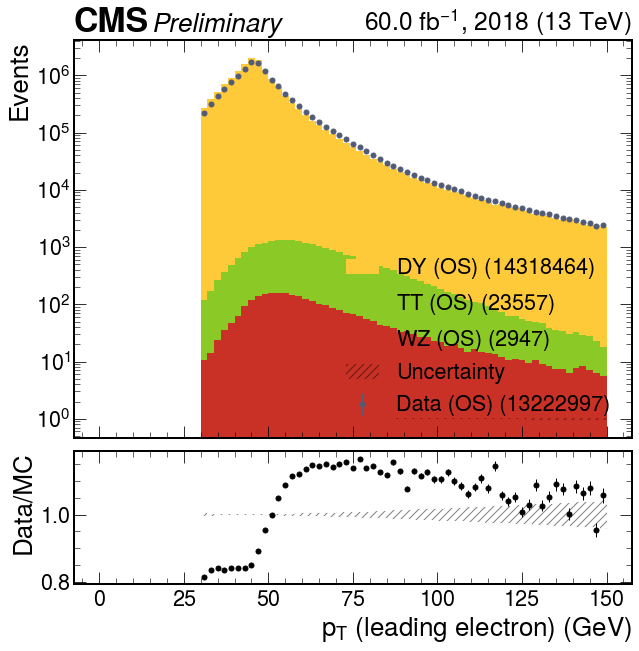

In [24]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['pt_DY1_OS'].edges,
    w2=[hists[x].errors**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['pt_data1_OS'].counts],
    hists['pt_data1_OS'].edges,
    w2=hists['pt_data1_OS'].errors**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['pt_data1_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['pt_data1_OS'].counts/(hists['pt_TT1_OS'].counts+hists['pt_DY1_OS'].counts+hists['pt_WZ1_OS'].counts)**2],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$p_{T}\ (leading\ electron)\ (GeV)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zpt(l)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zpt(l)_data.pdf')

In [25]:
hists = {
    'pt_data2_OS': h2,
    'pt_DY2_OS':   h2_DY,
    'pt_TT2_OS':   h2_TT,
    'pt_WZ2_OS':   h2_WZ,
}

hists['pt_DY2_OS'].label = '$DY\ (OS)$'
hists['pt_DY2_OS'].color = '#FFCA3A'

hists['pt_TT2_OS'].label = '$TT\ (OS)$'
hists['pt_TT2_OS'].color = '#8AC926'

hists['pt_WZ2_OS'].label = '$WZ\ (OS)$'
hists['pt_WZ2_OS'].color = '#C93126'

keys = ['pt_WZ2_OS', 'pt_TT2_OS', 'pt_DY2_OS']

total_mc = get_total(hists, keys)

ratio = (hists['pt_data2_OS']).divide(hists['pt_TT2_OS']+hists['pt_DY2_OS']+hists['pt_WZ2_OS'])

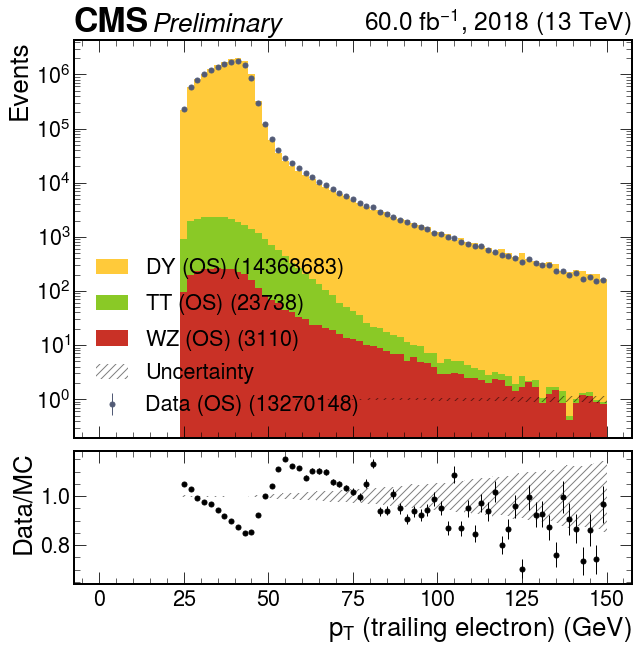

In [27]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['pt_DY2_OS'].edges,
    w2=[hists[x].errors**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['pt_data2_OS'].counts],
    hists['pt_data2_OS'].edges,
    w2=hists['pt_data2_OS'].errors**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['pt_data2_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['pt_data2_OS'].counts/(hists['pt_TT2_OS'].counts+hists['pt_DY2_OS'].counts+hists['pt_WZ2_OS'].counts)**2],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$p_{T}\ (trailing\ electron)\ (GeV)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zpt(t)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zpt(t)_data.pdf')

In [28]:
hists = {
    'eta_data1_OS': h3,
    'eta_DY1_OS':   h3_DY,
    'eta_TT1_OS':   h3_TT,
    'eta_WZ1_OS':   h3_WZ,
}

hists['eta_DY1_OS'].label = '$DY\ (OS)$'
hists['eta_DY1_OS'].color = '#FFCA3A'

hists['eta_TT1_OS'].label = '$TT\ (OS)$'
hists['eta_TT1_OS'].color = '#8AC926'

hists['eta_WZ1_OS'].label = '$WZ\ (OS)$'
hists['eta_WZ1_OS'].color = '#C93126'

keys = ['eta_WZ1_OS', 'eta_TT1_OS', 'eta_DY1_OS']

total_mc = get_total(hists, keys)

ratio = (hists['eta_data1_OS']).divide(hists['eta_TT1_OS']+hists['eta_DY1_OS']+hists['eta_WZ1_OS'])

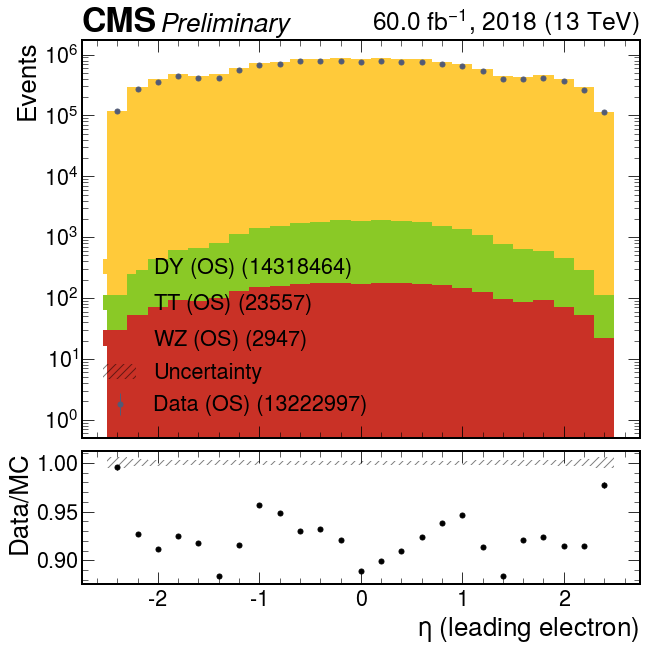

In [29]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['eta_DY1_OS'].edges,
    w2=[hists[x].errors**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['eta_data1_OS'].counts],
    hists['eta_data1_OS'].edges,
    w2=hists['eta_data1_OS'].errors**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['eta_data1_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['eta_data1_OS'].counts/(hists['eta_TT1_OS'].counts+hists['eta_DY1_OS'].counts+hists['eta_WZ1_OS'].counts)**2],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$\eta\ (leading\ electron)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zeta(l)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zeta(l)_data.pdf')

In [30]:
hists = {
    'eta_data2_OS': h4,
    'eta_DY2_OS':   h4_DY,
    'eta_TT2_OS':   h4_TT,
    'eta_WZ2_OS':   h4_WZ,
}

hists['eta_DY2_OS'].label = '$DY\ (OS)$'
hists['eta_DY2_OS'].color = '#FFCA3A'

hists['eta_TT2_OS'].label = '$TT\ (OS)$'
hists['eta_TT2_OS'].color = '#8AC926'

hists['eta_WZ2_OS'].label = '$WZ\ (OS)$'
hists['eta_WZ2_OS'].color = '#C93126'

keys = ['eta_WZ2_OS', 'eta_TT2_OS', 'eta_DY2_OS']

total_mc = get_total(hists, keys)

ratio = (hists['eta_data2_OS']).divide(hists['eta_TT2_OS']+hists['eta_DY2_OS']+hists['eta_WZ2_OS'])

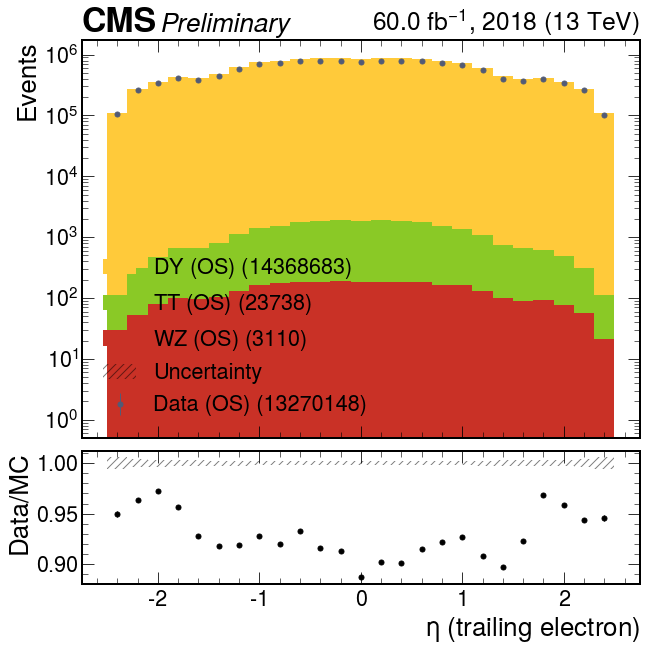

In [32]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['eta_DY2_OS'].edges,
    w2=[hists[x].errors**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['eta_data2_OS'].counts],
    hists['eta_data2_OS'].edges,
    w2=hists['eta_data2_OS'].errors**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['eta_data2_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['eta_data2_OS'].counts/(hists['eta_TT2_OS'].counts+hists['eta_DY2_OS'].counts+hists['eta_WZ2_OS'].counts)**2],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$\eta\ (trailing\ electron)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zeta(t)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zeta(t)_data.pdf')

In [33]:
hists = {
    'phi_data1_OS': h5,
    'phi_DY1_OS':   h5_DY,
    'phi_TT1_OS':   h5_TT,
    'phi_WZ1_OS':   h5_WZ,
}

hists['phi_DY1_OS'].label = '$DY\ (OS)$'
hists['phi_DY1_OS'].color = '#FFCA3A'

hists['phi_TT1_OS'].label = '$TT\ (OS)$'
hists['phi_TT1_OS'].color = '#8AC926'

hists['phi_WZ1_OS'].label = '$WZ\ (OS)$'
hists['phi_WZ1_OS'].color = '#C93126'

keys = ['phi_WZ1_OS', 'phi_TT1_OS', 'phi_DY1_OS']

total_mc = get_total(hists, keys)

ratio = (hists['phi_data1_OS']).divide(hists['phi_TT1_OS']+hists['phi_DY1_OS']+hists['phi_WZ1_OS'])

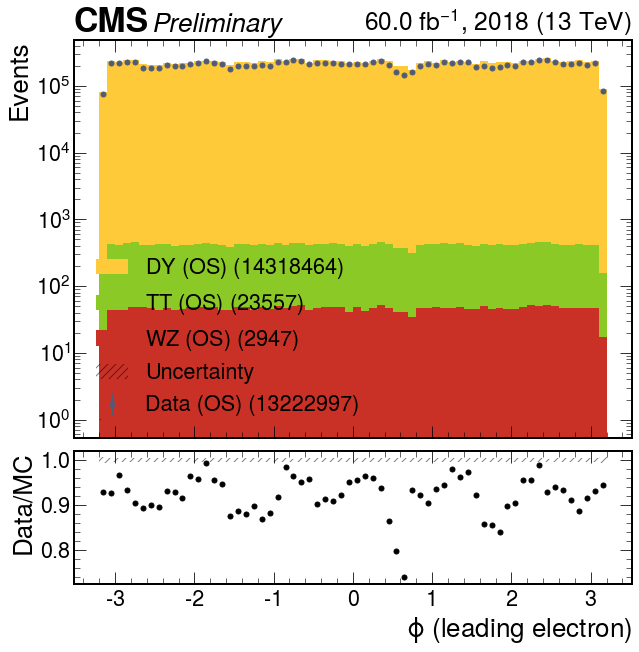

In [34]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['phi_DY1_OS'].edges,
    w2=[hists[x].errors**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['phi_data1_OS'].counts],
    hists['phi_data1_OS'].edges,
    w2=hists['phi_data1_OS'].errors**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['phi_data1_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['phi_data1_OS'].counts/(hists['phi_TT1_OS'].counts+hists['phi_DY1_OS'].counts+hists['phi_WZ1_OS'].counts)**2],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$\phi\ (leading\ electron)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zphi(l)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zphi(l)_data.pdf')

In [35]:
hists = {
    'phi_data2_OS': h6,
    'phi_DY2_OS':   h6_DY,
    'phi_TT2_OS':   h6_TT,
    'phi_WZ2_OS':   h6_WZ,
}

hists['phi_DY2_OS'].label = '$DY\ (OS)$'
hists['phi_DY2_OS'].color = '#FFCA3A'

hists['phi_TT2_OS'].label = '$TT\ (OS)$'
hists['phi_TT2_OS'].color = '#8AC926'

hists['phi_WZ2_OS'].label = '$WZ\ (OS)$'
hists['phi_WZ2_OS'].color = '#C93126'

keys = ['phi_WZ2_OS', 'phi_TT2_OS', 'phi_DY2_OS']

total_mc = get_total(hists, keys)

ratio = (hists['phi_data2_OS']).divide(hists['phi_TT2_OS']+hists['phi_DY2_OS']+hists['phi_WZ2_OS'])

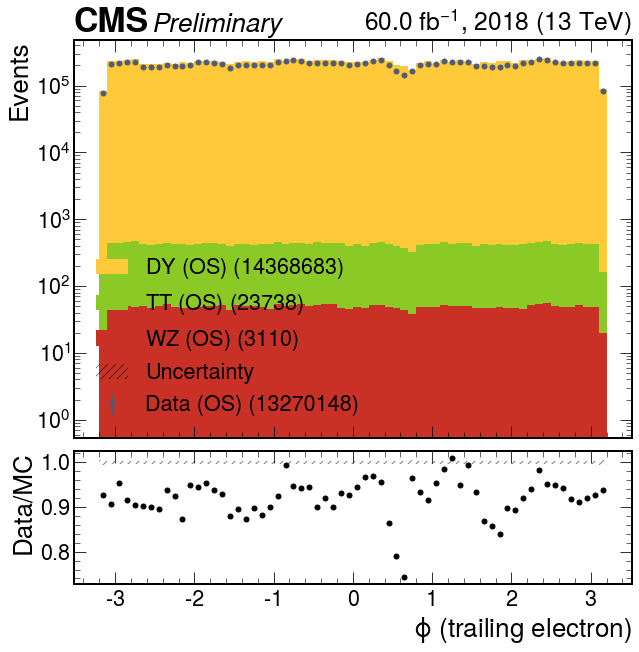

In [36]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['phi_DY2_OS'].edges,
    w2=[hists[x].errors**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['phi_data2_OS'].counts],
    hists['phi_data2_OS'].edges,
    w2=hists['phi_data2_OS'].errors**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['phi_data2_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['phi_data2_OS'].counts/(hists['phi_TT2_OS'].counts+hists['phi_DY2_OS'].counts+hists['phi_WZ2_OS'].counts)**2],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$\phi\ (trailing\ electron)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/zphi(t)_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/zphi(t)_data.pdf')

In [40]:
tmp1 = output[0]['MET'].copy()
tmp1 = tmp1.rebin('pt', pt_rebin)

if year == 2018:
    h1 = Hist1D.from_bincounts(
        tmp1.sum('phi', 'dataset').values()[()].T,
        (tmp1.axis('pt').edges()),
        errors = np.sqrt(tmp1.sum('phi', 'dataset').values(sumw2=True)[()][1].T),
    )

    tmp2 = mc_output['MET'].copy()
    tmp2 = tmp2.rebin('pt', pt_rebin)

    h1_DY = Hist1D.from_bincounts(
        tmp2.sum('phi').values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('pt').edges()),
        errors = np.sqrt(tmp2.sum('phi').values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h1_DY = h1_DY*6021.0*1000/100108281.94794683*60

    h1_TT = Hist1D.from_bincounts(
        tmp2.sum('phi').values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('pt').edges()),
        errors = np.sqrt(tmp2.sum('phi').values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h1_TT = h1_TT*87.315*1000/4635769336.539396*60

    h1_WZ = Hist1D.from_bincounts(
            tmp2.sum('phi').values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
            (tmp2.axis('pt').edges()),
            errors = np.sqrt(tmp2.sum('phi').values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
        )

    h1_WZ = h1_WZ*4.666*1000/97448995.340155*60

In [41]:
hists = {'MET_pt_data_OS': h1,
         'MET_pt_DY_OS': h1_DY,
         'MET_pt_TT_OS': h1_TT,
         'MET_pt_WZ_OS': h1_WZ,
}

hists['MET_pt_DY_OS'].label = '$DY\ (OS)$'
hists['MET_pt_DY_OS'].color = '#FFCA3A'

hists['MET_pt_TT_OS'].label = '$TT\ (OS)$'
hists['MET_pt_TT_OS'].color = '#8AC926'

hists['MET_pt_WZ_OS'].label = '$WZ\ (OS)$'
hists['MET_pt_WZ_OS'].color = '#C93126'

keys = ['MET_pt_WZ_OS', 'MET_pt_TT_OS', 'MET_pt_DY_OS']

total_mc = get_total(hists, keys)

ratio = (hists['MET_pt_data_OS']).divide(hists['MET_pt_TT_OS']+hists['MET_pt_DY_OS']+hists['MET_pt_WZ_OS'])

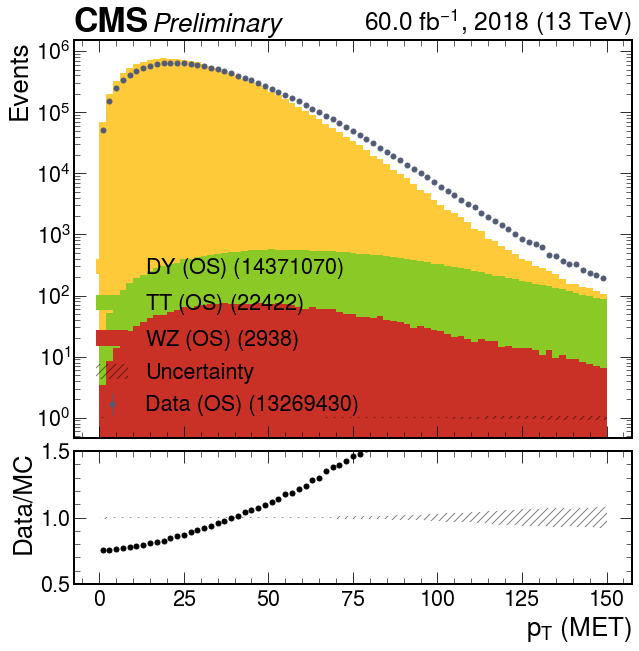

In [42]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['MET_pt_DY_OS'].edges,
    w2=[hists[x].errors**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['MET_pt_data_OS'].counts],
    hists['MET_pt_data_OS'].edges,
    w2=hists['MET_pt_data_OS'].errors**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['MET_pt_data_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['MET_pt_data_OS'].counts/(hists['MET_pt_TT_OS'].counts+hists['MET_pt_DY_OS'].counts+hists['MET_pt_WZ_OS'].counts)**2],
    histtype="errorbar",
    color=['black'],
    ax=rax)

rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$p_{T}\ (MET)$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/metpt_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/metpt_data.pdf')

In [43]:
tmp1 = output[0]['N_jet'].copy()
tmp1 = tmp1.rebin('multiplicity', N_bins_red)

if year == 2018:
    
    h1 = Hist1D.from_bincounts(
        tmp1.sum('dataset').values()[()].T,
        (tmp1.axis('multiplicity').edges()),
        errors = np.sqrt(tmp1.sum('dataset').values(sumw2=True)[()][1].T),
    )

    tmp2 = mc_output['N_jet'].copy()
    tmp2 = tmp2.rebin('multiplicity', N_bins_red)

    h1_DY = Hist1D.from_bincounts(
        tmp2.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('multiplicity').edges()),
        errors = np.sqrt(tmp2.values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h1_DY = h1_DY*6021.0*1000/100108281.94794683*60

    h1_TT = Hist1D.from_bincounts(
        tmp2.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('multiplicity').edges()),
        errors = np.sqrt(tmp2.values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h1_TT = h1_TT*87.315*1000/4635769336.539396*60
    
    h1_WZ = Hist1D.from_bincounts(
            tmp2.values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
            (tmp2.axis('multiplicity').edges()),
            errors = np.sqrt(tmp2.values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
        )

    h1_WZ = h1_WZ*4.666*1000/97448995.340155*60

In [44]:
hists = {'N_jet_data_OS': h1,
         'N_jet_DY_OS': h1_DY,
         'N_jet_TT_OS': h1_TT,
         'N_jet_WZ_OS': h1_WZ,
}

hists['N_jet_DY_OS'].label = '$DY\ (OS)$'
hists['N_jet_DY_OS'].color = '#FFCA3A'

hists['N_jet_TT_OS'].label = '$TT\ (OS)$'
hists['N_jet_TT_OS'].color = '#8AC926'

hists['N_jet_WZ_OS'].label = '$WZ\ (OS)$'
hists['N_jet_WZ_OS'].color = '#C93126'

keys = ['N_jet_WZ_OS', 'N_jet_TT_OS', 'N_jet_DY_OS']

total_mc = get_total(hists, keys)

ratio = (hists['N_jet_data_OS']).divide(hists['N_jet_TT_OS']+hists['N_jet_DY_OS']+hists['N_jet_WZ_OS'])

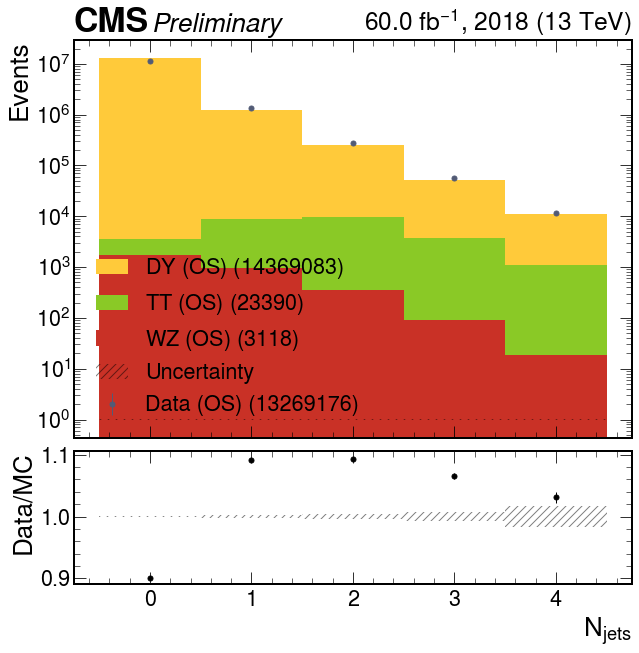

In [46]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['N_jet_DY_OS'].edges,
    w2=[hists[x].errors**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['N_jet_data_OS'].counts],
    hists['N_jet_data_OS'].edges,
    w2=hists['N_jet_data_OS'].errors**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['N_jet_data_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['N_jet_data_OS'].counts/(hists['N_jet_TT_OS'].counts+hists['N_jet_DY_OS'].counts+hists['N_jet_WZ_OS'].counts)**2],
    histtype="errorbar",
    color=['black'],
    ax=rax)

#rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$N_{jets}$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/njet_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/njet_data.pdf')

In [47]:
tmp1 = output[0]['PV_npvsGood3'].copy()

if year == 2018:
    
    h1 = Hist1D.from_bincounts(
        tmp1.sum('dataset').values()[()].T,
        (tmp1.axis('multiplicity').edges()),
        errors = np.sqrt(tmp1.sum('dataset').values(sumw2=True)[()][1].T),
    )

    tmp2 = mc_output['PV_npvsGood3'].copy()

    h1_DY = Hist1D.from_bincounts(
        tmp2.values()[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('multiplicity').edges()),
        errors = np.sqrt(tmp2.values(sumw2=True)[('/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h1_DY = h1_DY*6021.0*1000/100108281.94794683*60

    h1_TT = Hist1D.from_bincounts(
        tmp2.values()[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
        (tmp2.axis('multiplicity').edges()),
        errors = np.sqrt(tmp2.values(sumw2=True)[('/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
    )

    h1_TT = h1_TT*87.315*1000/4635769336.539396*60
    
    h1_WZ = Hist1D.from_bincounts(
            tmp2.values()[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)].T,
            (tmp2.axis('multiplicity').edges()),
            errors = np.sqrt(tmp2.values(sumw2=True)[('/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM',)][1].T),
        )

    h1_WZ = h1_WZ*4.666*1000/97448995.340155*60

In [48]:
hists = {'PV_nGood_data_OS': h1,
         'PV_nGood_DY_OS': h1_DY,
         'PV_nGood_TT_OS': h1_TT,
         'PV_nGood_WZ_OS': h1_WZ
}

hists['PV_nGood_DY_OS'].label = '$DY\ (OS)$'
hists['PV_nGood_DY_OS'].color = '#FFCA3A'

hists['PV_nGood_TT_OS'].label = '$TT\ (OS)$'
hists['PV_nGood_TT_OS'].color = '#8AC926'

hists['PV_nGood_WZ_OS'].label = '$WZ\ (OS)$'
hists['PV_nGood_WZ_OS'].color = '#C93126'

keys = ['PV_nGood_WZ_OS', 'PV_nGood_TT_OS', 'PV_nGood_DY_OS']

total_mc = get_total(hists, keys)

ratio = (hists['PV_nGood_data_OS']).divide(hists['PV_nGood_TT_OS']+hists['PV_nGood_DY_OS']+hists['PV_nGood_WZ_OS'])

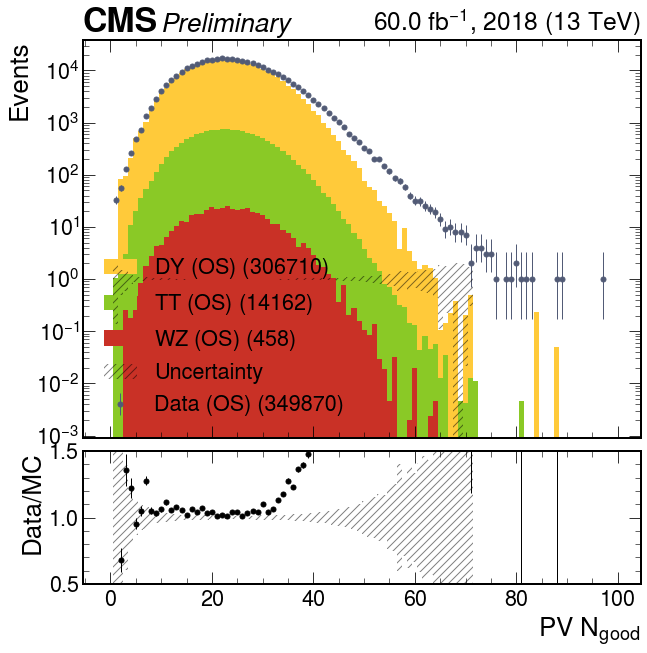

In [49]:
fig, (ax, rax) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)
hep.cms.label(
    'Preliminary',
    data=True,
    year=2018,
    lumi=60.0,
    loc=0,
    ax=ax,
)

hep.histplot(
    [hists[x].counts for x in keys ],
    hists['PV_nGood_DY_OS'].edges,
    w2=[hists[x].errors**2 for x in keys ],
    histtype="fill",
    stack=True,
    label=['%s (%.0f)'%(hists[x].label, sum(hists[x].counts)) for x in keys],
    color=[ hists[x].color for x in keys ],
    ax=ax)

hep.histplot(
    [hists['PV_nGood_data_OS'].counts],
    hists['PV_nGood_data_OS'].edges,
    w2=hists['PV_nGood_data_OS'].errors**2,
    histtype="errorbar",
    stack=False,
    label=['%s (%.0f)'%('Data (OS)', np.sum(hists['PV_nGood_data_OS'].counts+hists['PV_nGood_WZ_OS'].counts))],
    color=['#525B76'],
    ax=ax)

hep.histplot(
    [ratio.counts],
    ratio.edges,
    w2=[hists['PV_nGood_data_OS'].counts/(hists['PV_nGood_TT_OS'].counts+hists['PV_nGood_DY_OS'].counts)**2],
    histtype="errorbar",
    color=['black'],
    ax=rax)

rax.set_ylim(0.5,1.5)
rax.set_xlabel(r'$PV\ N_{good}$')
rax.set_ylabel(r'Data/MC')
ax.set_ylabel(r'Events')
ax.set_yscale('log')
#ax.set_ylim(0.1,1e5)

add_uncertainty(total_mc, ax, ratio=True)
add_uncertainty(total_mc, rax, ratio=True)

ax.legend()

plt.show()

fig.savefig('/home/users/ewallace/public_html/FCNC/pvngood_data.png')
fig.savefig('/home/users/ewallace/public_html/FCNC/pvngood_data.pdf')